In [12]:
import numpy as np
import os
from astropy.io import fits
from astropy.stats import LombScargle
from photutils import aperture_photometry as photometry
from photutils import CircularAperture as circle
from photutils import CircularAnnulus as annulus
from photutils import RectangularAperture as rectangle
from photutils import ApertureMask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.set_printoptions(threshold=np.nan)


                                                Initial Setup

In [13]:
initial_directory = '/Users/Olive/Desktop/kelt pipeline/Full Images' # path of directory that contains full image fits files
cutout_directory = '/Users/Olive/Desktop/kelt pipeline/testCut/' # location for image cutouts

all_files=os.listdir(initial_directory) #extract list of files
file_count = len(all_files) # gives number of files in directory
sort_files = sorted(all_files) # sort directory in alphanumeric order
full_img_list = [os.path.join(initial_directory, sort_files[i]) for i in range(0,file_count)] # create file path names for full image files

                                                Creating Image Cutouts

In [14]:
#cell containing cutout dimensions
#4005, 2121

cutout_x_start = 3966
cutout_x_stop = 4046
cutout_y_start = 2081
cutout_y_stop = 2161

In [15]:
# a loop to create image cutouts
for i in range(0,file_count):
    image=fits.open(full_img_list[i]) #open file
    imageData = image[1].data  #take out data from file (data is in 'section' 1)
    image.close()
    image_cutout_data= imageData[cutout_y_start:cutout_y_stop, cutout_x_start:cutout_x_stop]  #choose area of data to keep
    image_cutout = fits.PrimaryHDU(image_cutout_data)  #assign data to new fits file
    cutoutName='cutout_'+all_files[i][len(all_files[i])-20:] #appends 'cutout' to the date and id of photo
    destination=cutout_directory+cutoutName  #define destination of new file. CHANGE, GO THROUGH ALL IMAGES IN A STAR
    image_cutout.writeto(destination)  #save fits file    

OSError: File '/Users/Olive/Desktop/kelt pipeline/testCut/cutout_20100321.163.fits.fz' already exists.

In [ ]:
# create file path names for full image files
cutout_img_list = [os.path.join(cutout_directory, sorted(os.listdir(cutout_directory))[i]) for i in range(0,file_count)]
open_cutouts =[]
for i in range (0,file_count):
    image=fits.open(cutout_img_list[i]) #open file
    imageData = image[0].data  #take out data from file (data is in 'section' 1)
    image.close()
    open_cutouts.append(imageData)

                                        Producing a Light Curve and Phase Curve

In [16]:
# cell for upcoming variables not previously defined
display_file = 0 # target file number to display target image
target_img_size = 20 # x by x pixel size of target image

x_aperture = 9 # x coordinate of target aperture center within the star cutout 
y_aperture = 9 # y coordinate of target aperture center within the star cutout 
r = 2 # radius of target aperture

x_background = x_aperture # x coordinate of background annulus center
y_background = y_aperture # y coordinate of background annulus center
r_in = 8 # inner radius of background annulus (in pixels)
r_out = r_in + 1 # outer radius of background annulus

low_period = 1.5 # lowest period for LombScargle to test on target star
high_period = 100# highest period for LombScargle to test on target star

comparison_stars= np.loadtxt('FNAQL_stars.txt', skiprows=1)

create images to visualize the target

In [23]:
# The following data for this star is given in the VizieR database
# name: FN Aql, period: 9.48151 days, RA and dec: (19:12:47.3112, +03:33:26.712), magnitude range: (8.110, 8.680)

center = len(open_cutouts[display_file])/2 # calculate center location of target image
target = open_cutouts[display_file][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] # create array of target image data values for specified file
aperture_main_cutout = circle((x_aperture,y_aperture), r) # create circular aperture around target
background_main_cutout = annulus((x_background,y_background), r_in, r_out) # create annulus for background flux

#place aperture and annulus  of main star on large image
offset = (len(open_cutouts[display_file])-target_img_size)/2 # calculate difference between center coordinates of target image and comparison stars image
aperture_large_cutout = circle((x_aperture+offset,y_aperture+offset), r) # place aperture on target star in comparison stars image
background_large_cutout = annulus((x_background+offset,y_background+offset), r_in, r_out) # place background annulus so that it is surrounding target star in comparison stars image

# define comparison star coordinates and radii from an existing text file 
comparison_star_circles= [] # empty list for background star circles
for i in range(len(comparison_stars)):
    newStar = comparison_stars[i] #ientify row for clearer use in the next line
    comparison_star_circles.append(circle((newStar[0],newStar[1]), r=newStar[2])) # create list of circles to plot

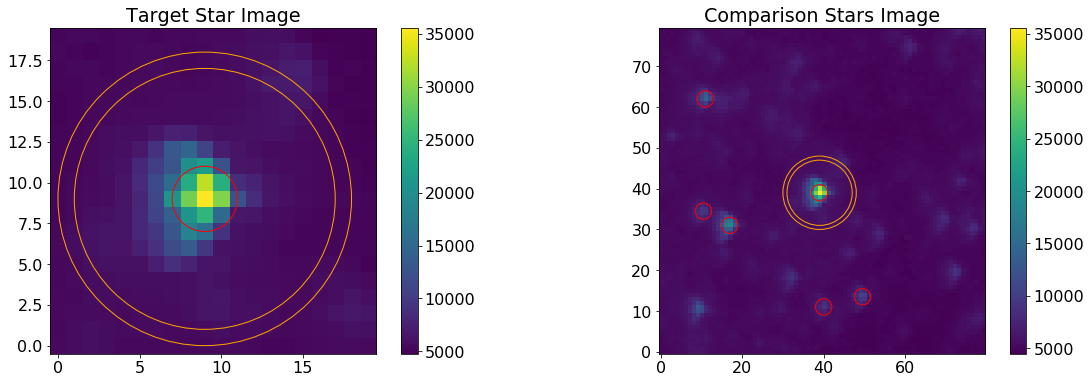

In [24]:
# create target image with target aperture and background annulus
mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

plt.subplot(121)
plt.title('Target Star Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

# create comparison stars image with target aperture, comparison apertures, and background annulus
plt.subplot(122)
plt.title('Comparison Stars Image')
plt.imshow(open_cutouts[display_file], origin='lower')
plt.colorbar()
aperture_large_cutout.plot(color='red')
background_large_cutout.plot(color='orange')
for i in range(len(comparison_star_circles)): comparison_star_circles[i].plot(color='red')
plt.show()


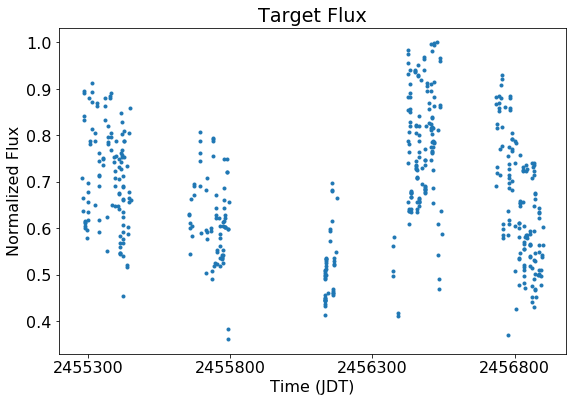

In [25]:
background_mask = background_large_cutout.to_mask(method='center') # create mask over pixels in background annulus that have their centers within the annulus 
background_data = [background_mask[0].multiply(open_cutouts[i]) for i in range(0,file_count)] # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
background_flux = [background_data[i][background_mask[0].data > 0] for i in range(0,file_count)] # create array of flux values contained in mask
background_median = [np.median(background_flux[i]) for i in range(0,file_count)] # find median of background flux array

# create target flux vs. time plot
target_sum = [photometry(open_cutouts[i], aperture_large_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_background_sum = [background_median[i] * aperture_large_cutout.area() for i in range(0,file_count)] # multiply background median by area of aperture to get background flux contained in aperture
target_subtract = np.array([target_sum[i]['aperture_sum'] - target_background_sum[i] for i in range(0,file_count)]) # subtract background flux in aperture from aperture's total flux

target_flux = target_subtract[target_subtract != 0] # disregard zero and below flux values 

time=[]
for i in range(0,len(target_flux)):
    original_file = fits.open(full_img_list[i])
    time.append(original_file[1].header['JDT'])
    original_file.close

new_target_flux = []          
for i in range(0,len(target_flux)):
    norm = target_flux[i]/max(target_flux)
    new_target_flux.append(norm)     
    
cut_time=[]
cut_flux=[]
for i in range(0,len(time)):
    if time[i]<2456900:
        cut_time.append(time[i])
        cut_flux.append(new_target_flux[i])

plt.subplot(121)
plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/5,-2)))
#plt.plot(time, new_target_flux, '.')
plt.plot(cut_time, cut_flux, '.')

comparison_sum = [[photometry(open_cutouts[i], comparison_star_circles[j], method = 'exact') for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))] # sum up exact amount of flux contained in each comparison star aperture
comparison_background_sum = [[background_median[i] * comparison_star_circles[j].area() for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))] # multiply background median by area of each aperture to get background flux contained in each aperture
comparison_subtract = np.array([[comparison_sum[j][i]['aperture_sum'] - comparison_background_sum[j][i] for i in range(0,file_count)] for j in range(0,len(comparison_star_circles))]) # subtract background flux in each aperture from each aperture's total flux
comparison_total = comparison_subtract.sum(axis=0) # sum up the background subtracted flux for all comparison stars
comparison_flux = comparison_total[comparison_total != 0] # disregard zero flux values

comparison_time=[]
for i in range(0,len(comparison_flux)):
    original_file = fits.open(full_img_list[i])
    comparison_time.append(original_file[1].header['JDT'])
    original_file.close


find point cutoff point in time and find why they dont fit in after
list of inages and their values 

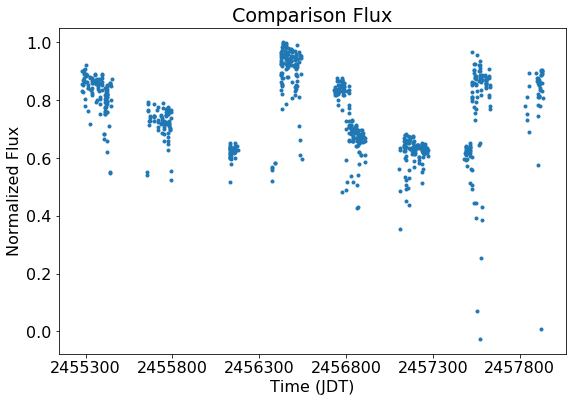

In [9]:
# create comparison flux vs. time plot

plt.subplot(122)
plt.title('Comparison Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/5,-2)))
plt.plot(comparison_time, comparison_flux/max(comparison_flux), '.')
plt.show()



In [26]:
final_flux = np.subtract(target_flux, comparison_flux) # subtract target flux from comparison flux

# use Lomb-Scargle Periodogram to test period range on target 
frequency, power = LombScargle(time, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period)
    
best_frequency = frequency[np.argmax(power)] # find frequency with highest power value
period = 1/best_frequency # convert this frequency to a period
low = np.argmin(final_flux) # find lowest value of flux 
phase_offset = 0.5 - np.remainder(time[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
phase = np.remainder(time + phase_offset * period, period * 2) / period # calculate the phase of the target flux for two cycles


In [ ]:

# create target light curve with target flux minus comparison flux vs. time 
plt.title('Target Light Curve')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))
plt.plot(time, (final_flux - min(final_flux))/(max(final_flux)-min(final_flux)), '.') 
plt.show()

# create target periodogram with power vs. period

plt.subplot(121)
plt.plot(1/frequency, power)
plt.title('Target Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')

# create target phase curve with flux vs. phase

plt.subplot(122)
plt.plot(phase, (final_flux - min(final_flux))/max(final_flux-min(final_flux)), '.')
plt.title('Target Phase Curve')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.show()

# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", period, "days")
print("power value for best period = ", max(power))

In [11]:
print('time and flux')
for i in range(0,len(time)):
    print (str(time[i])+'   '+str(final_flux[i]))

time and flux
2455277.625232   -5766.207066305738
2455280.61774   -39255.01529353758
2455281.620792   -12070.057023188623
2455284.607181   51997.576287914766
2455284.632335   50203.32253684636
2455285.605691   44392.46566088451
2455285.628763   34663.68216559003
2455288.59306   -42820.41517822168
2455288.597503   -41651.14788933183
2455288.615229   -44574.287560796685
2455288.637376   -46885.2892393636
2455288.641809   -44011.18276099954
2455297.58325   -25967.805867290503
2455297.608431   -25696.57238709394
2455298.606797   -47351.03942385805
2455299.578428   -35742.54433406872
2455299.6467   -38821.063030001416
2455300.61844   -16557.931135628634
2455300.645687   -16643.00148748918
2455304.598244   39545.530212553655
2455305.555935   15474.129913217563
2455305.581118   11322.138270069147
2455312.543175   56215.484740185406
2455312.563866   60226.744295517594
2455312.586657   49532.165884330636
2455312.61367   53039.44827335881
2455324.517692   13132.546717499528
2455324.542931   1849

                                                Creating Flux Histogram

In [21]:
# cell for upcoming variables not previously defined

bin_size = 5000 # bin size for histogram

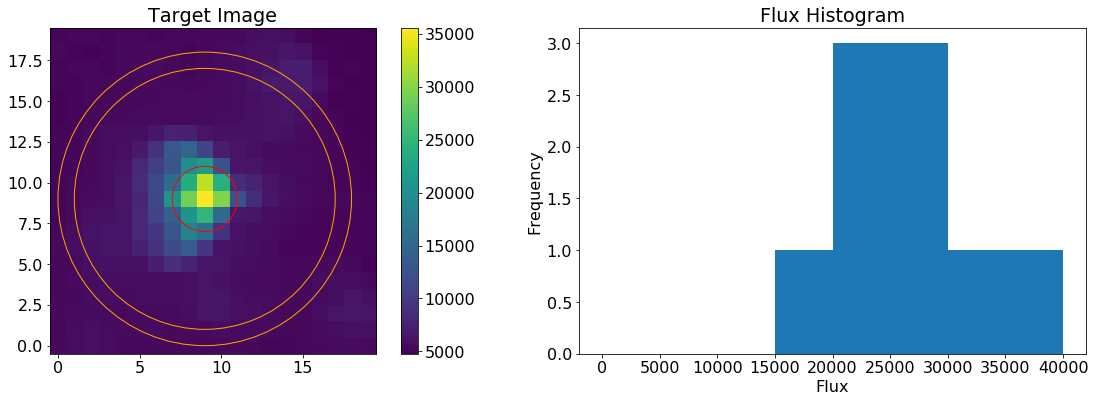

In [22]:
# create target image with target aperture and background annulus


plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

aperture_mask = aperture_main_cutout.to_mask(method='center') # create mask over pixels in target aperture that have their centers within the annulus 
aperture_data = aperture_mask[0].multiply(target) # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
aperture_flux = aperture_data[aperture_mask[0].data > 0] # create array of flux values contained in mask

# create bins for histogram up to highest flux value in aperture
bins = np.arange(0,max(np.ndarray.flatten(target)+bin_size),bin_size) 

# create flux histrogram of values within target aperture
plt.subplot(122)
plt.hist(aperture_flux, bins);
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Frequency');
plt.show()

                                            Examining Abnormal Flux Values

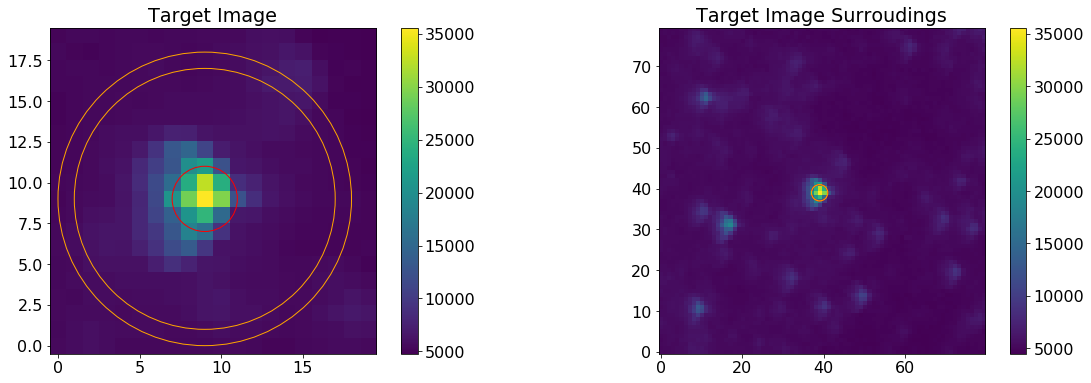

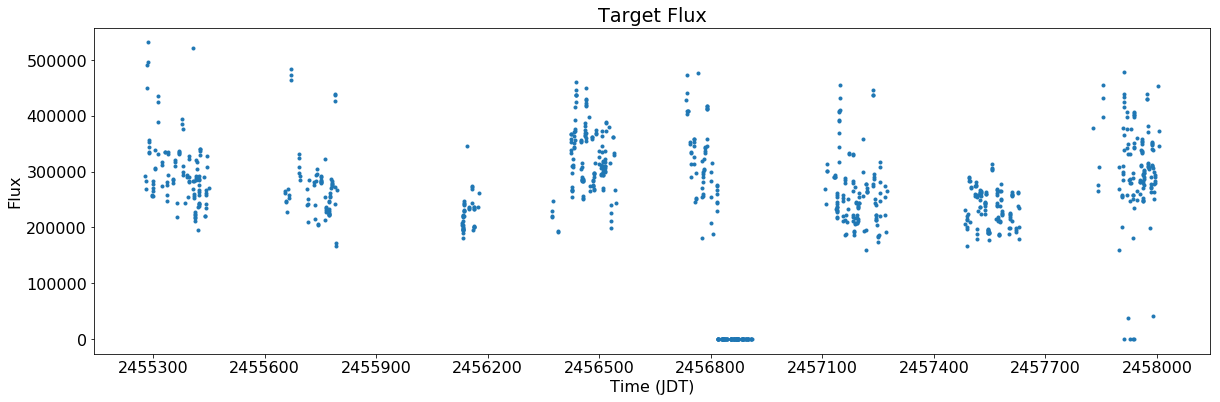

Low Flux Values

File    Target Flux
432          0.0
433          0.0
434          0.0
435          0.0
436          0.0
437          0.0
438          0.0
439          0.0
440          0.0
441          0.0
442          0.0
443          0.0
444          0.0
445          0.0
446          0.0
447          0.0
448          0.0
449          0.0
450          0.0
451          0.0
452          0.0
453          0.0
454          0.0
455          0.0
456          0.0
457          0.0
458          0.0
459          0.0
460          0.0
461          0.0
462          0.0
463          0.0
464          0.0
465          0.0
466          0.0
467          0.0
468          0.0
469          0.0
470          0.0
471          0.0
472          0.0
473          0.0
474          0.0
475          0.0
476          0.0
477          0.0
478          0.0
479          0.0
480          0.0
481          0.0
482          0.0
483          0.0
484          0.0
485          0.0
486          0.0
487          0.0
488        

In [25]:

# create target image with target aperture and background annulus
plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')



mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

target_data = [open_cutouts[i][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] for i in range(0,file_count)] # create array of target image data values for all files
target_sum = [photometry(target_data[i], aperture_main_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_flux = np.array([target_sum[i]['aperture_sum'] for i in range (0,file_count)]) # get flux of target aperture without disregarding zero flux values


# create surrounding area image with target aperture and background annulus

plt.subplot(122)
plt.title('Target Image Surroudings')
plt.imshow(open_cutouts[display_file], origin='lower')
plt.colorbar() 
aperture_large_cutout.plot(color='red') 
aperture_large_cutout.plot(color='orange')
plt.show()

#redefine time to contain timestamps even of 0 flux images
time=[]
for i in range(0,len(open_cutouts)):
    original_file = fits.open(full_img_list[i])
    time.append(original_file[1].header['JDT'])
    original_file.close

# create light curve for target flux with zero flux values

plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Flux')
plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))
plt.plot(time, target_flux, '.')
plt.show()


low_flux = 100000
high_flux = np.inf # upper limit for target flux values


# print flux values and corresponding file number for values that fall outside specified limits

print("Low Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux < low_flux])):
    print(np.add(np.where(target_flux < low_flux),1)[0][i], "        ", target_flux[target_flux < low_flux][i])
print("")
print("")
print("")
print("High Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux > high_flux])):
    print(np.add(np.where(target_flux > high_flux),1)[0][i], "        ", target_flux[target_flux > high_flux][i])